In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr

In [2]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
sample = sample[sample["v_asym_g"]/sample["v_asym_g_err"]>3]
sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

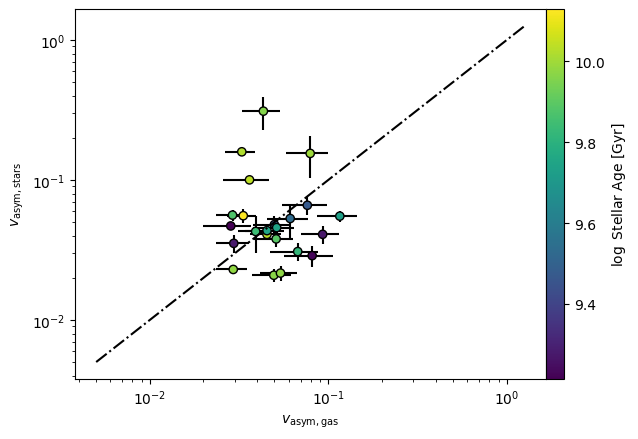

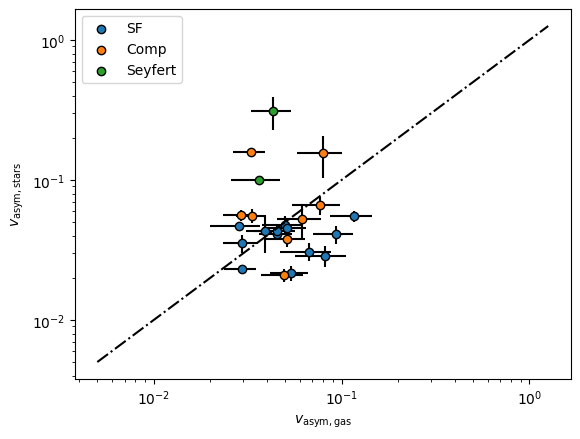

In [3]:
vg = sample["v_asym_g"].to_numpy()
vg_err = sample['v_asym_g_err'].to_numpy()
vs = sample["v_asym_s"].to_numpy()
vs_err = sample["v_asym_s_err"].to_numpy()

fig,ax = plt.subplots()
p=ax.scatter(vs,vg,ec="k",c=ssp["logage_MW_2re"].to_numpy(),zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
plt.colorbar(p,ax=ax,label=r"$\log$ Stellar Age [Gyr]",pad=0,fraction=0.05)
plt.show()

fig,ax = plt.subplots()
for i,lab in zip([1,0,2],["SF","Comp","Seyfert"]):
    ax.scatter(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==i],
               ec="k",zorder=2,label=lab)
    ax.errorbar(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                xerr=vs_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                yerr=vg_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
ax.legend()
plt.show()

/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/1494097953.py:19: RuntimeWarning: divide by zero encountered in log10
  if 0.5 > (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > -1:
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/1494097953.py:21: RuntimeWarning: divide by zero encountered in log10
  if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > 0.5:
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/1494097953.py:23: RuntimeWarning: divide by zero encountered in log10
  if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) < -1:
/Volumes/DS/MAGPI/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/1494097953.py:51: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor r

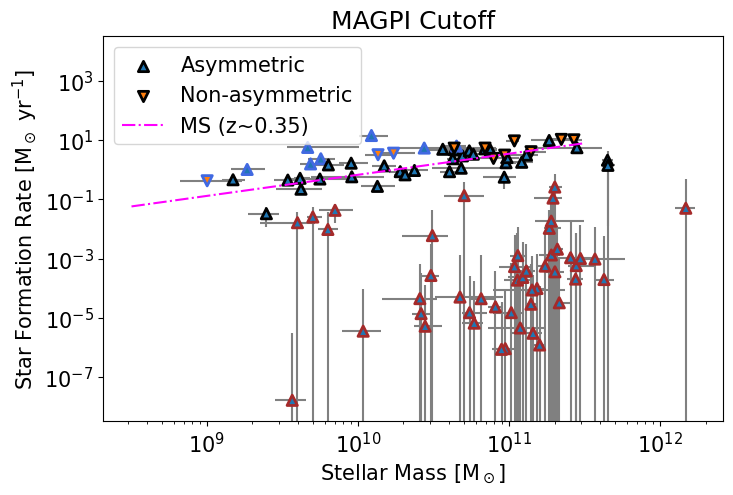

In [4]:
xx = np.logspace(8.5,11.5, 55)
MS = (xx**0.712)*(10**-7.293)

sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()
mass_err_16 = mass-prospect["StellarMass_16"].to_numpy()
mass_err_84 = prospect["StellarMass_84"].to_numpy()-mass
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
SFR = bpt["SFR, dust corrected"].to_numpy()
SFR_err = bpt["SFR_err"].to_numpy()
asym = sample["v_asym_s"].to_numpy()
D_SFR = []
for x,y in zip(mass,SFR):
    if 0.5 > (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > -1:
        D_SFR.append(1) # Star Forming
    if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > 0.5:
        D_SFR.append(2) # Starbursting
    if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) < -1:
        D_SFR.append(0)
colors=[]
for i in D_SFR:
    if i==1:
        colors.append("k")
    if i==2:
        colors.append("royalblue")
    if i==0:
        colors.append("brown")
colors=np.array(colors)
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(mass[asym>0.04],SFR[asym>0.04], zorder=2, ec=colors[asym>0.04], label="Asymmetric",s=55,linewidths=1, marker="^",lw=2)
ax.errorbar(mass[asym>0.04],SFR[asym>0.04],xerr=np.array([mass_err_16[asym>0.04],mass_err_84[asym>0.04]]),yerr=SFR_err[asym>0.04], c='gray', zorder=1, ls="")
ax.scatter(mass[asym<0.04],SFR[asym<0.04], zorder=2, ec=colors[asym<0.04], label="Non-asymmetric",s=55, linewidths=1, marker="v",lw=2)
ax.errorbar(mass[asym<0.04],SFR[asym<0.04],xerr=np.array([mass_err_16[asym<0.04],mass_err_84[asym<0.04]]), yerr=SFR_err[asym<0.04], c='gray', zorder=1, ls="")
ax.plot(xx,MS, c="magenta", ls="dashdot", label="MS (z~0.35)")
#ax.plot(xx,MS*0.1, c="magenta", ls="dashdot")
#ax.plot(xx,MS*10, c="magenta", ls="dashdot")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(10**(-8.5),10**(4.5))
ax.set_xlabel("Stellar Mass [M$_\odot$]")
ax.set_ylabel("Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax.legend(loc="upper left")
ax.set_title("MAGPI Cutoff")
for i in range(2):
    ax.legend_.legendHandles[i].set_edgecolor("k")
plt.savefig("plots/paper2/SFMS_asym_Ha.pdf", bbox_inches="tight")

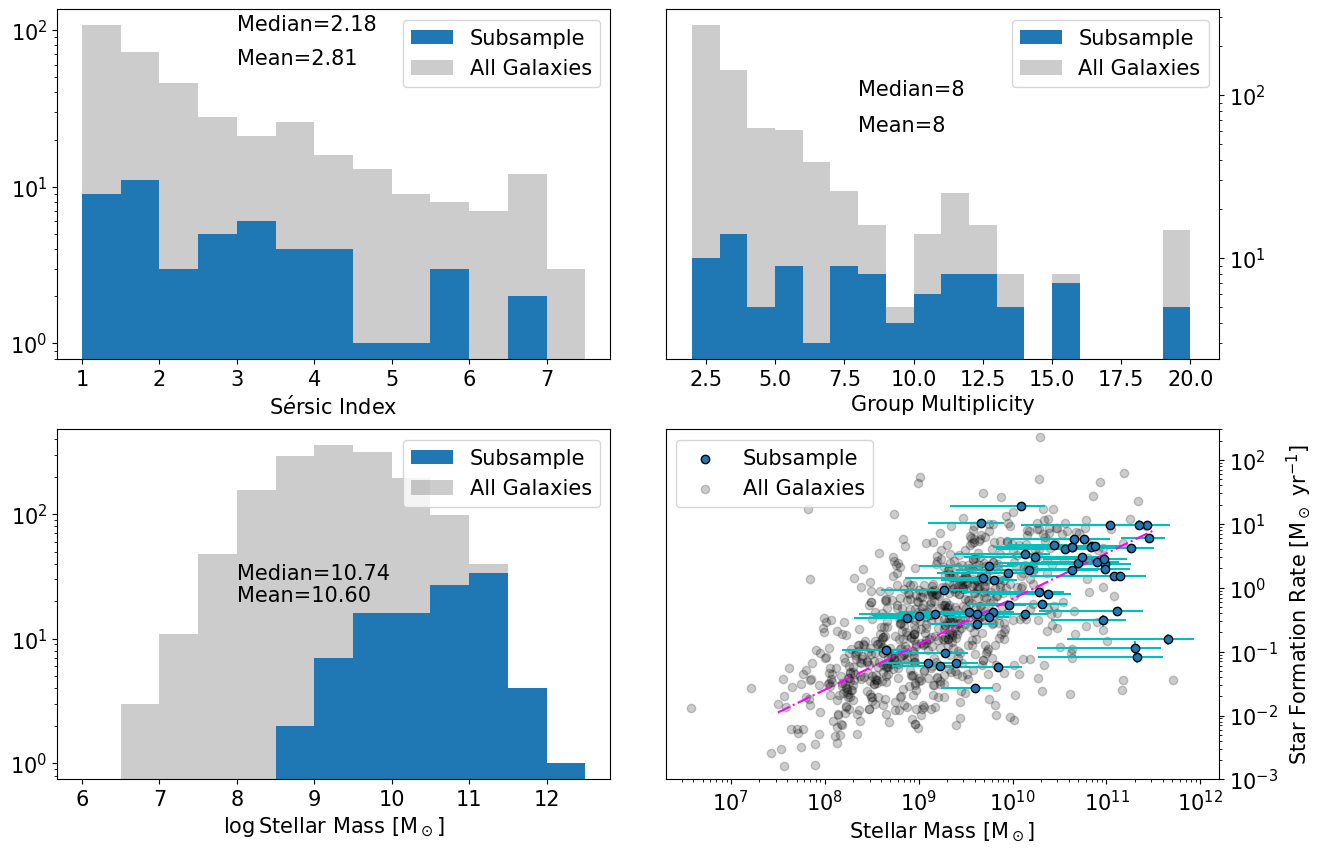

In [5]:
#sample = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
#sample = sample.dropna()
#sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")

# SFMS & Mass
t = ascii.read("MAGPI_csv/MAGPI_Balmer_SFRs_onedspec.tbl")
df=pd.DataFrame({"MAGPIID":np.array(t['MAGPI_ID']),
                "SFR":np.array(t["SFR"]),
                "SFR_err":np.array(t["SFR_err"])})
df1 = df[df["MAGPIID"].isin(sample["MAGPIID"])]
df2 = df[~df["MAGPIID"].isin(sample["MAGPIID"])]
SFR = df1["SFR"].to_numpy()
SFR_err = df1["SFR_err"].to_numpy()
SFR_2 = df2["SFR"].to_numpy()
M_sol = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_median"].to_numpy()
M_sol_err = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_16"].to_numpy()
M_sol_2 = prospect[prospect["MAGPIID"].isin(df2["MAGPIID"])]["StellarMass_median"].to_numpy()
xx = np.logspace(7.5,11.5, 55)
MS = (xx**0.712)*(10**-7.293)

# Environment
env = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_env.csv")
N_Gals = env[env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]
not_N_gals = env[~env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]

# Sersic
file1 = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
file1 = file1.dropna()
file1 = file1.drop_duplicates(["MAGPIID"])
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.0.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
n2 = galfit["n"]
n2 = n2[n2 > 0]
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(prospect["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(prospect["MAGPIID"])]
n = galfit["n"]
n = n[n > 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
# Sersic
ax1.hist(n, zorder=2, label="Subsample", bins=np.arange(1,8,0.5))
ax1.hist(n2, label="All Galaxies", color="k", bins=np.arange(1,8,0.5), alpha=0.2)
ax1.text(s=f"Median={np.median(n):.2f}", x=3, y=100)
ax1.text(s=f"Mean={np.mean(n):.2f}", x=3, y=60)
#ax.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"S$\'{e}$rsic Index")
ax1.legend()
# Environment
ax2.hist(N_Gals, label="Subsample", zorder=2,bins=np.arange(1,21,1))
#ax2.hist(N_Gals_0, zorder=2, label="No Env. Metrics")
ax2.hist(not_N_gals, label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,21,1))
ax2.set_yscale("log")
ax2.set_xlabel("Group Multiplicity")
ax2.text(s=f"Median={np.median(N_Gals):.0f}", x=8, y=100)
ax2.text(s=f"Mean={np.mean(N_Gals):.0f}", x=8, y=60)
ax2.legend()
ax2.set_xlim(1.05,21.05)
# Mass
ax3.hist(np.log10(M_sol), zorder=2, label="Subsample", bins=np.arange(6,13,0.5))
ax3.hist(np.log10(M_sol_2), label="All Galaxies", color="k", bins=np.arange(6,13,0.5), alpha=0.2)
ax3.text(s=f"Median={np.median(np.log10(M_sol)):.2f}", x=8, y=30)
ax3.text(s=f"Mean={np.mean(np.log10(M_sol)):.2f}", x=8, y=20)
#ax.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel(r"$\log$Stellar Mass [M$_\odot$]")
ax3.legend()
# SFMS
ax4.scatter(M_sol, SFR, zorder=3, label="Subsample", ec="k")
ax4.errorbar(M_sol, SFR, xerr=M_sol_err, yerr=SFR_err, zorder=2, fmt=".c", ls="")
ax4.scatter(M_sol_2, SFR_2, zorder=1, alpha=0.2, c="k", label="All Galaxies")
ax4.plot(xx, MS, ls="dashdot", c="magenta")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(1e-3, 300)
ax4.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax4.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax4.legend()
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig("plots/paper2/SFMS_Mass_Sersic_Env.pdf", bbox_inches="tight")

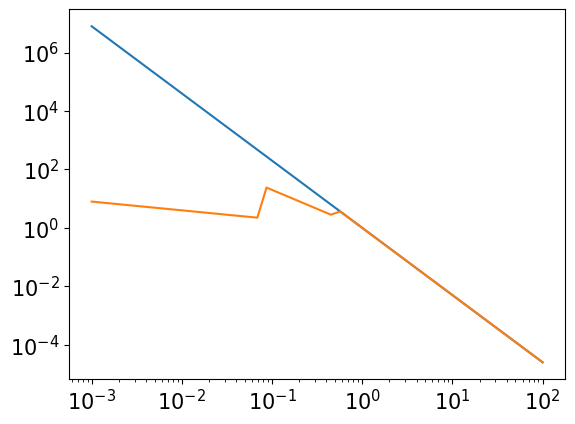

In [6]:
def salpeter(M):
    return M**(-2.3)
def kroupa(M):
    if M<0.08:
        return M**(-0.3)
    if 0.08<M<0.5:
        return M**(-1.3)
    if M>0.5:
        return M**(-2.3)
kroupa = np.vectorize(kroupa)
M = np.logspace(-3,2)
fig,ax = plt.subplots()
ax.plot(M,salpeter(M))
ax.plot(M,kroupa(M))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [7]:
sample = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
#sample=sample[sample["v_asym_tot"]/sample['v_asym_tot_err']>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_BPT.csv")
bpt = bpt[bpt['MAGPIID'].isin(sample["MAGPIID"])]

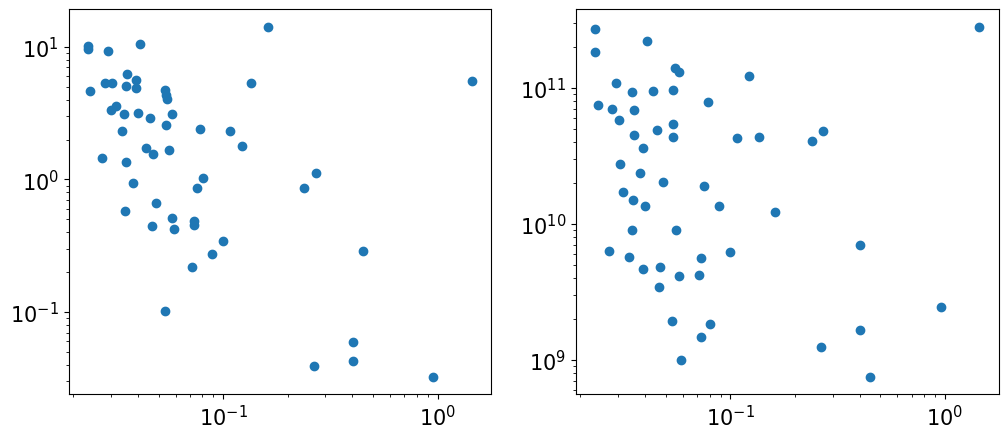

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.scatter(sample["v_asym_tot"].to_numpy(),bpt["SFR, dust corrected"].to_numpy())
ax2.scatter(sample['v_asym_tot'].to_numpy(),prospect["StellarMass_median"].to_numpy())
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.show()

PearsonRResult(statistic=-0.5290493734909835, pvalue=3.907896424941457e-05)
PearsonRResult(statistic=-0.27122717805209584, pvalue=0.04727512091310414)


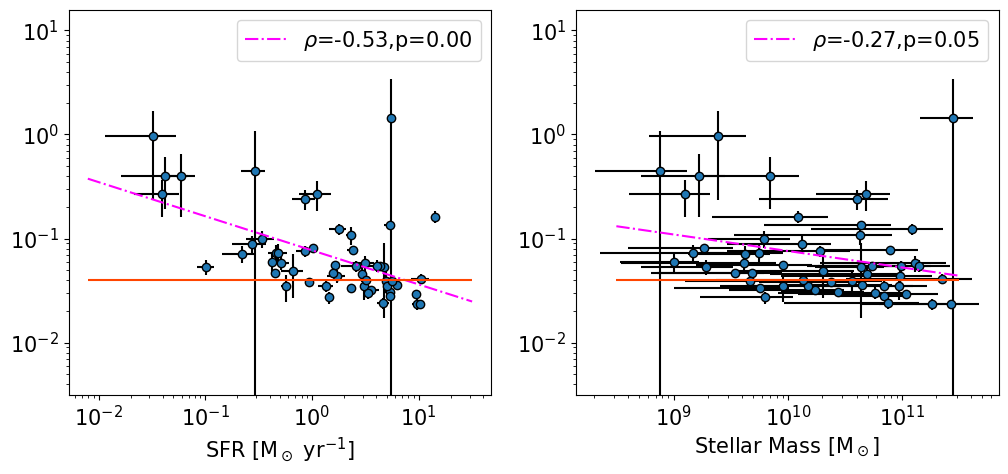

In [9]:
import scipy
x = np.log10(sample['v_asym_tot'].to_numpy())
y = np.log10(bpt['SFR, dust corrected'].to_numpy())
z = np.log10(prospect["StellarMass_median"].to_numpy())
x = x[~np.isnan(y)]
z = z[~np.isnan(y)]
y = y[~np.isnan(y)]
y = y[~np.isnan(x)]
z = z[~np.isnan(x)]
x = x[~np.isnan(x)]
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
lt = [y,z]
for i in range(2):
    res = scipy.stats.linregress(lt[i],x)
    per = scipy.stats.pearsonr(lt[i],x)
    print(per)
    if i==0:
        ax1.scatter(bpt["SFR, dust corrected"].to_numpy(),sample["v_asym_tot"].to_numpy(),zorder=2,ec="k")
        ax1.errorbar(bpt["SFR, dust corrected"].to_numpy(),sample["v_asym_tot"].to_numpy(), xerr=bpt["SFR_err"].to_numpy(),yerr=sample['v_asym_tot_err'].to_numpy(), fmt=".k",zorder=1)
        xx = np.logspace(-2.1,1.5)
        ax1.plot(xx,(10**res[1])*(xx**res[0]),ls="dashdot",zorder=2,color="magenta",label=r"$\rho$="+f"{per[0]:.2f}"+r",p="+f"{per[1]:.2f}")
        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_ylim(10**(-2.5),10**(1.2))
        ax1.hlines(0.04,xx[0],xx[-1],zorder=2,color="orangered")
        ax1.legend()
        ax1.set_xlabel(r"SFR [M$_\odot$ yr$^{-1}$]")
    if i==1:
        ax2.scatter(prospect["StellarMass_median"].to_numpy(),sample['v_asym_tot'].to_numpy(),zorder=2,ec="k")
        ax2.errorbar(prospect["StellarMass_median"].to_numpy(),sample["v_asym_tot"].to_numpy(), xerr=prospect["StellarMass_16"].to_numpy(),
                     yerr=sample['v_asym_tot_err'].to_numpy(), fmt=".k",zorder=1)
        xx = np.logspace(8.5,11.5)
        ax2.plot(xx,(10**res[1])*(xx**res[0]),ls="dashdot",zorder=2,color="magenta",label=r"$\rho$="+f"{per[0]:.2f}"+r",p="+f"{per[1]:.2f}")
        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_ylim(10**(-2.5),10**(1.2))
        ax2.hlines(0.04,xx[0],xx[-1],zorder=2,color="orangered")
        ax2.legend()
        ax2.set_xlabel(r"Stellar Mass [M$_\odot$]")
plt.show()

In [10]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from kinemetry import kinemetry
from kinemetry_plots import clean_images
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
source_cat = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_source_catalogue.csv")
source_cat = source_cat[source_cat["MAGPIID"].isin(sample["MAGPIID"])]
galaxy = sample['MAGPIID'].to_numpy()
pa = source_cat["ang_it"].to_numpy()
q = source_cat["axrat_it"].to_numpy()
r50 = source_cat["R50_it"].to_numpy()/0.2
z = source_cat["z"].to_numpy()
pix = np.radians((0.33/0.2))*cosmo.luminosity_distance(z).to(u.kpc).value
vg = sample['v_asym_g'].to_numpy()
vs = sample["v_asym_s"].to_numpy()
srad = np.zeros(len(sample))
srot = np.zeros(len(sample))
grad = np.zeros(len(sample))
grot = np.zeros(len(sample))
for i in range(len(sample["MAGPIID"])):
    if np.isnan(vg[i]):
        print("Do kinemetry only on stars")
        field = str(galaxy[i])[:4]
        starfile = fits.open("MAGPI_Absorption_Lines/MAGPI"+field+"/galaxies/"+str(galaxy[i])+"_kinematics_ppxf-maps.fits")
        s_flux, s_velo, s_velo_err, s_sigma = starfile[7].data, starfile[1].data, starfile[3].data, starfile[4].data
        starfile.close()
        y0, x0 = s_flux.shape
        x0 = int(x0 / 2)
        y0 = int(y0 / 2)
        start = (0.65 / 2) / 0.2
        step = (0.65 / 2) / 0.2
        end = 2 * r50[i]
        rad = np.arange(start, end, step)
        ks = kinemetry(img=s_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,
                       bmodel=True, rangePA=[0, 360], rangeQ=[q[i] - 0.1, q[i] + 0.1], allterms=True,
                       cover=0.95)
        if np.abs(np.nanmin(ks.cf[:,1])) > np.abs(np.nanmax(ks.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmin(ks.cf[:,1]):.2f}")
            srad[i]=np.nanmin(ks.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(ks.cf[:,2]):.2f}")
            srot[i]=np.nanmax(ks.cf[:,2])
        if np.abs(np.nanmin(ks.cf[:,1])) < np.abs(np.nanmax(ks.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmax(ks.cf[:,1]):.2f}")
            srad[i]=np.nanmax(ks.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(ks.cf[:,2]):.2f}")
            srot[i]=np.nanmax(ks.cf[:,2])
        else:
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmax(ks.cf[:,1]):.2f}")
            srad[i]=np.nanmax(ks.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(ks.cf[:,2]):.2f}")
            srot[i]=np.nanmax(ks.cf[:,1])
    if np.isnan(vs[i]):
        print("Do kinemetry only on gas")
        field = str(galaxy[i])[:4]
        gasfile = fits.open("MAGPI_Emission_Lines/MAGPI"+field+"/MAGPI"+field+"_v2.2.1_GIST_EmissionLine_Maps/MAGPI"+str(galaxy[i])+"_GIST_EmissionLines.fits")
        g_flux, g_flux_err, g_velo, g_velo_err, g_sigma = gasfile[49].data, gasfile[50].data, gasfile[9].data, \
                                                          gasfile[10].data, gasfile[11].data
        gasfile.close()
        g_velo = clean_images(g_velo, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
        g_velo_err = clean_images(g_velo_err, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
        g_flux = clean_images(g_flux, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
        g_flux = g_flux / g_flux_err
        y0, x0 = s_flux.shape
        x0 = int(x0 / 2)
        y0 = int(y0 / 2)
        start = (0.65 / 2) / 0.2
        step = (0.65 / 2) / 0.2
        end = 2 * r50[i]
        rad = np.arange(start, end, step)
        kg = kinemetry(img=g_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,
                       bmodel=True, rangePA=[0, 360], rangeQ=[q[i] - 0.1, q[i] + 0.1], allterms=True,
                       cover=0.95)
        if np.abs(np.nanmin(kg.cf[:,1])) > np.abs(np.nanmax(kg.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmin(kg.cf[:,1]):.2f}")
            grad[i]=np.nanmin(kg.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(kg.cf[:,2]):.2f}")
            grot[i]=np.nanmax(kg.cf[:,2])
        if np.abs(np.nanmin(kg.cf[:,1])) < np.abs(np.nanmax(kg.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmax(kg.cf[:,1]):.2f}")
            grad[i]=np.nanmax(kg.cf[:,1])
            #print("Stellar Rot Velocity")
            grot[i]=np.nanmax(kg.cf[:,2])
            #print(f"{np.nanmax(kg.cf[:,2]):.2f}")
    if not np.isnan(vs[i]) and not np.isnan(vg[i]):
        print("Do kinemetry on both")
        field = str(galaxy[i])[:4]
        starfile = fits.open("MAGPI_Absorption_Lines/MAGPI"+field+"/galaxies/"+str(galaxy[i])+"_kinematics_ppxf-maps.fits")
        s_flux, s_velo, s_velo_err, s_sigma = starfile[7].data, starfile[1].data, starfile[3].data, starfile[4].data
        starfile.close()
        y0, x0 = s_flux.shape
        x0 = int(x0 / 2)
        y0 = int(y0 / 2)
        start = (0.65 / 2) / 0.2
        step = (0.65 / 2) / 0.2
        end = 2 * r50[i]
        rad = np.arange(start, end, step)
        ks = kinemetry(img=s_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,
                       bmodel=True, rangePA=[0, 360], rangeQ=[q[i] - 0.1, q[i] + 0.1], allterms=True,
                       cover=0.95)
        if np.abs(np.nanmin(ks.cf[:,1])) > np.abs(np.nanmax(ks.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmin(ks.cf[:,1]):.2f}")
            srad[i]=np.nanmin(ks.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(ks.cf[:,2]):.2f}")
            srot[i]=np.nanmax(ks.cf[:,2])
        if np.abs(np.nanmin(ks.cf[:,1])) < np.abs(np.nanmax(ks.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmax(ks.cf[:,1]):.2f}")
            srad[i]=np.nanmax(ks.cf[:,1])
            #print("Stellar Rot Velocity")
            #print(f"{np.nanmax(ks.cf[:,2]):.2f}")
            srot[i]=np.nanmax(ks.cf[:,2])
        field = str(galaxy[i])[:4]
        gasfile = fits.open("MAGPI_Emission_Lines/MAGPI"+field+"/MAGPI"+field+"_v2.2.1_GIST_EmissionLine_Maps/MAGPI"+str(galaxy[i])+"_GIST_EmissionLines.fits")
        g_flux, g_flux_err, g_velo, g_velo_err, g_sigma = gasfile[49].data, gasfile[50].data, gasfile[9].data, \
                                                          gasfile[10].data, gasfile[11].data
        gasfile.close()
        g_velo = clean_images(g_velo, pa[i], r50[i], r50[i] * q[i], img_err=g_flux / g_flux_err)
        g_velo_err = clean_images(g_velo_err, pa[i], r50[i], r50[i] * q[i], img_err=g_flux / g_flux_err)
        g_flux = clean_images(g_flux, pa[i], r50[i], r50[i] * q[i], img_err=g_flux / g_flux_err)
        g_flux = g_flux / g_flux_err
        y0, x0 = s_flux.shape
        x0 = int(x0 / 2)
        y0 = int(y0 / 2)
        start = (0.65 / 2) / 0.2
        step = (0.65 / 2) / 0.2
        end = 2 * r50[i]
        rad = np.arange(start, end, step)
        kg = kinemetry(img=g_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,
                       bmodel=True, rangePA=[0, 360], rangeQ=[q[i] - 0.1, q[i] + 0.1], allterms=True,
                       cover=0.95)
        if np.abs(np.nanmin(kg.cf[:,1])) > np.abs(np.nanmax(kg.cf[:,1])):
            #print("Stellar Radial Velocity")
            #print(f"{np.nanmin(kg.cf[:,1]):.2f}")
            grad[i]=np.nanmin(kg.cf[:,1])
            # print("Stellar Rot Velocity")
            # print(f"{np.nanmax(kg.cf[:,2]):.2f}")
            grot[i]=np.nanmax(kg.cf[:,2])
        if np.abs(np.nanmin(kg.cf[:,1])) < np.abs(np.nanmax(kg.cf[:,1])):
            # print("Stellar Radial Velocity")
            # print(f"{np.nanmax(kg.cf[:,1]):.2f}")
            grad[i]=np.nanmax(kg.cf[:,1])
            # print("Stellar Rot Velocity")
            grot[i]=np.nanmax(kg.cf[:,2])
            # print(f"{np.nanmax(kg.cf[:,2]):.2f}")


Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both


/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/3390641116.py:143: RuntimeWarning: All-NaN slice encountered
  if np.abs(np.nanmin(kg.cf[:,1])) > np.abs(np.nanmax(kg.cf[:,1])):
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/3390641116.py:150: RuntimeWarning: All-NaN slice encountered
  if np.abs(np.nanmin(kg.cf[:,1])) < np.abs(np.nanmax(kg.cf[:,1])):


Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry on both
Do kinemetry on both
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry only on stars
Do kinemetry on both
Do kinemetry on both
Do kinemetry on both


(array([ 2.,  1., 12.,  3.,  5.,  5.,  4.,  3.,  8.,  1.]),
 array([-71.81865566, -40.45830614,  -9.09795663,  22.26239289,
         53.6227424 ,  84.98309192, 116.34344143, 147.70379095,
        179.06414046, 210.42448998, 241.78483949]),
 <BarContainer object of 10 artists>)

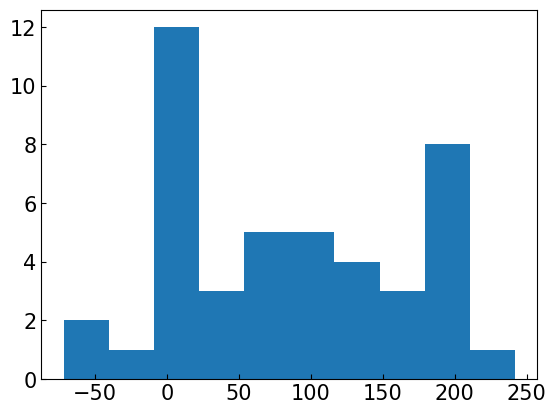

In [11]:
plt.hist(srot)

In [12]:
srad[srad==0]=np.nan
srot[srot==0]=np.nan

/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_44412/3545386401.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(srad/srot))


(array([ 1.,  0.,  7.,  5.,  2.,  6.,  0.,  1.,  0., 12.]),
 array([-3.40110413, -3.06099371, -2.7208833 , -2.38077289, -2.04066248,
        -1.70055206, -1.36044165, -1.02033124, -0.68022083, -0.34011041,
         0.        ]),
 <BarContainer object of 10 artists>)

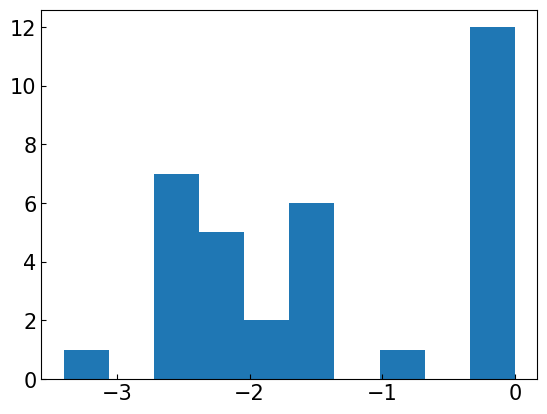

In [13]:
plt.hist(np.log10(srad/srot))